# Tensorflow RNN

A recurrent neural network written in pure tensorflow.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
num_pixels = width*height

# pixel permutation idxs
perm_idxs = list(range(num_pixels))
np.random.RandomState(seed=0).shuffle(perm_idxs)

# reverse pixel permutation idxs
rev_perm_idxs = [perm_idxs.index(i) for i in range(num_pixels)]

# Training Parameters
num_steps = 2000   # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Batch Size
test_batch_size = 1000 # batch size for calculating the validation/test loss

# RNN Parameters
num_inputs = 1 # input dimension [1=pixel-by-pixel]
num_steps_rnn = num_pixels // num_inputs # sequential dimensionality of rnn
num_hidden_rnn = 128 # hidden layer dimension
num_layers_rnn = 1 # number of hidden layers

# Optimization parameters
learning_rate = 0.0001 # Learning rate

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

As a preprocessing step, the labels are converted to a one-hot encoded sparse matrix. [One hot encoding](https://en.wikipedia.org/wiki/One-hot) is just a way of replacing each integer in the label vector with a row of zeros, except at the position specified by the integer, where you put a 1.

Note that the inverse transformation of the one-hot encoding can always be performed by taking the `argmax` along `axis=1`.

Secondly, the image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In contrast with the Convolutional Neural Networks, we do a pixel-by-pixel recognition of the digit image where the individial digits are permuted with a fixed permutation defined by `perm_idx`. This fixed permutation is necessary for good performance of the RNN, as otherwise the the end of the pixel stream contains too many zeros for the RNN to retain its internal state. This is a good benchmark task for a recurrent neural network. The performance of this architecture will obviously be worse than for a convnet.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = np.int32(data[:,0])
    labels_onehot = np.zeros((len(labels), num_labels))
    labels_onehot[np.arange(len(labels)),labels] = 1
    values = (np.float32(data[:,1:])[:,perm_idxs].reshape(-1, num_steps_rnn, num_inputs)/255)
    return values, labels, labels_onehot

train_values, train_labels, train_labels_onehot = get_values_labels(train_data)
valid_values, valid_labels, valid_labels_onehot = get_values_labels(valid_data)
test_values, test_labels, test_labels_onehot = get_values_labels(test_data)

print(f'train data shape:\t\t{train_values.shape}')
print(f'train labels (one-hot) shape:\t{train_labels_onehot.shape}')

train data shape:		(50000, 784, 1)
train labels (one-hot) shape:	(50000, 10)


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

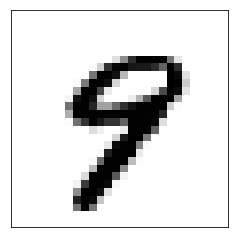

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(num_pixels)[rev_perm_idxs].reshape(width, height), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

In [5]:
class Model(object):
    def __init__(self):
        # inputs
        self.data = tf.placeholder(tf.float32, [None, num_steps_rnn, num_inputs])
        self.labels = tf.placeholder(tf.int64, [None])
        
        # weights and biases
        w_init_val = np.sqrt(6.)/np.sqrt(num_labels + num_inputs)
        self.w_rnn_out = tf.get_variable("w_rnn_out", shape = [num_hidden_rnn, num_labels], dtype=tf.float32, initializer=tf.random_uniform_initializer(-w_init_val, w_init_val))
        self.b_rnn_out = tf.get_variable("b_rnn_out", shape=[num_labels], dtype=tf.float32, initializer=tf.constant_initializer(0.01))
        
        # recurrent layer
        rnn_layer = lambda : tf.contrib.rnn.BasicLSTMCell(num_hidden_rnn)
        self.rnn_cell = tf.contrib.rnn.MultiRNNCell([rnn_layer() for _ in range(num_layers_rnn)])
        rnn_out, _ = tf.nn.dynamic_rnn(self.rnn_cell, self.data, dtype=tf.float32)

        # output layer
        logits = tf.matmul(rnn_out[:,-1,:], self.w_rnn_out) + self.b_rnn_out
        
        # prediction
        self.pred = tf.nn.softmax(logits)

        # loss & accuracy
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.labels))
        self.acc = 100*tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), self.labels), tf.float32))
        
        # optimizer
        self.opt = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        # initializer
        self.init = tf.global_variables_initializer()

# Train

Create the model

In [6]:
model = Model()

Open the session

In [7]:
session = tf.Session()
session.run(model.init)

Run the session

In [8]:
%%time
history = []
for step in range(num_steps):

    # calculate validation accuracy and loss
    if step%(train_size//batch_size) == 0 or step == num_steps -1:
        val_acc = np.zeros(valid_size//test_batch_size)
        val_loss = np.zeros(valid_size//test_batch_size)
        # we need to split the calculation of the validation loss in batches
        # to avoid memory problems.
        for i in range(0, valid_size, test_batch_size):
            fd={model.data:valid_values[i:i+test_batch_size], model.labels:valid_labels[i:i+test_batch_size]}
            val_acc[i//test_batch_size], val_loss[i//test_batch_size] = session.run([model.acc, model.loss], feed_dict=fd)
        history.append((step, val_loss.mean(), val_acc.mean()))
        print(f'Step {step:5.0f}\t Valid. Acc. = {val_acc.mean():5.2f}')
        
    # train
    idxs = np.random.randint(0, train_size, batch_size)
    session.run(model.opt, feed_dict={model.data:train_values[idxs], model.labels:train_labels[idxs]})

Step     0	 Valid. Acc. = 14.52
Step   500	 Valid. Acc. = 24.85
Step  1000	 Valid. Acc. = 30.61
Step  1500	 Valid. Acc. = 34.03
Step  1999	 Valid. Acc. = 37.09
CPU times: user 18min 54s, sys: 1min 32s, total: 20min 27s
Wall time: 9min 37s


Training history:

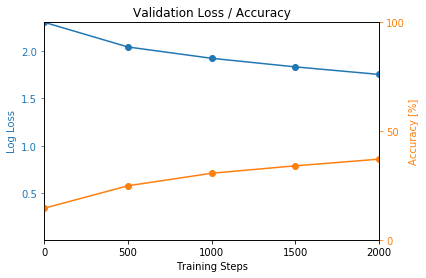

In [9]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(0,100)
plt.yticks([0,50,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
plt.ylim(0.01, 2.3)

plt.xlim(0, max(steps))
plt.xticks([0,num_steps//4, num_steps//2, 3*num_steps//4, num_steps])
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

note that we could run this longer for better accuracy.

# Test

Finally, the accuracy on the test set can be evaluated:

In [10]:
test_accuracy = np.zeros(test_size//test_batch_size)
# we need to split the calculation of the test loss in batches
# to avoid memory problems.
for i in range(0, test_size, test_batch_size):
    fd={model.data:test_values[i:i+test_batch_size], model.labels:test_labels[i:i+test_batch_size]}
    test_accuracy[i//test_batch_size] = session.run(model.acc, feed_dict=fd)
test_accuracy = test_accuracy.mean()
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 38.59


Visualize an example

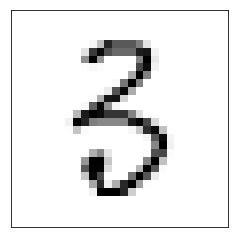

prediction=4	target=3


In [11]:
N = 315
show_digit(test_values[N])
prediction = np.argmax(session.run(model.pred, feed_dict={model.data:test_values[N:N+1]}).ravel())
print(f'prediction={prediction}\ttarget={test_labels[N]}')

In [12]:
session.close()